In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
import nltk

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pacharya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pacharya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pacharya\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
%matplotlib inline

In [6]:
df = pd.read_csv('onlinekhabar_news.csv')

In [8]:
df.head()

,source,category,link,nep_timestamp,en_timestamp,original_title,translated_title,original_content,translated_content,image_source,sentiment_score
0,OnlineKhabar,local,https://www.onlinekhabar.com/2024/11/1563247/c...,२०८१ कात्तिक २२ गते ८:३८,7-11-2024 08:38,कालीमाटीमा काउली र साग सस्तियो,Cauliflower and greens became cheaper in Kalimati,"२२ कात्तिक, काठमाडौं । कालीमाटी होलसेल बजारमा ...","22 November, Kathmandu. Greens have become che...",https://www.onlinekhabar.com/wp-content/upload...,1
1,OnlineKhabar,local,https://www.onlinekhabar.com/2024/11/1562755/g...,२०८१ कात्तिक २१ गते १०:३५,6-11-2024 10:350000000000001,तोलामा ३ सय बढ्यो सुन,Gold increased by 300 per tola,"२१ कात्तिक, काठमाडौं । बुधबार सुनको भाउ तोलामा...","21 October, Kathmandu. On Wednesday, the price...",https://www.onlinekhabar.com/wp-content/upload...,1
2,OnlineKhabar,local,https://www.onlinekhabar.com/2024/11/1562720/o...,२०८१ कात्तिक २१ गते ८:५१,6-11-2024 08:51,कालीमाटीमा प्याज महँगियो,Onion became expensive in Kalimati,"२१ कात्तिक, काठमाडौं । कालीमाटी होलसेल बजारमा ...","21 October, Kathmandu. Onion prices have incre...",https://www.onlinekhabar.com/wp-content/upload...,-1
3,OnlineKhabar,local,https://www.onlinekhabar.com/2024/11/1562305/a...,२०८१ कात्तिक २० गते १०:३८,5-11-2024 10:38,तिहारपछि तोलामा २९०० घट्यो सुन,"After Tihar, gold fell by 2,900 per tola","२० कात्तिक, काठमाडौं । तिहारपछि सुनको भाउ तोला...","20 October, Kathmandu. After Tihar, the price ...",https://www.onlinekhabar.com/wp-content/upload...,-1
4,OnlineKhabar,local,https://www.onlinekhabar.com/2024/11/1562267/a...,२०८१ कात्तिक २० गते ८:४७,5-11-2024 08:47,"तिहारपछि कालीमाटीमा गोलभेँडा सस्तियो, यस्तो छ ...","After Tihar, mutton became cheaper in Kalimati...","२० कात्तिक, काठमाडौं । कालीमाटी होलसेल बजारमा ...","20 October, Kathmandu. In the Kalimati wholesa...",https://www.onlinekhabar.com/wp-content/upload...,1


In [27]:
stop_words = set(stopwords.words('english')).union({
    "the", "of", "to", "in", "and", "is", "that", "a", "has", "was", "will", "be","per","also"
})

In [28]:
def clean_text(text):
    text = re.sub(r"<.*?>", " ", text)  # HTML tags
    text = re.sub(r"[^a-zA-Z\s]", " ", text)  # Special chars
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    filtered_tokens = [ word for word, tag in pos_tag(filtered_tokens) if tag not in ("VB", "VBD", "VBG", "VBN", "VBP", "VBZ")  # Verb tags
    ]
    return " ".join(filtered_tokens)

In [29]:
df['cleaned_title'] = df['translated_title'].apply(clean_text)
df['cleaned_title']

0                    cauliflower greens cheaper kalimati
1                                              gold tola
2                               onion expensive kalimati
3                                        tihar gold tola
4         tihar mutton cheaper kalimati price vegetables
                             ...                        
935                             kulman parliament people
936             earlier audit committee kulman authority
937      audit committee unsolicited documents authority
938    audit committee tod data authority truckload p...
939          credit discipline pose problem microfinance
Name: cleaned_title, Length: 940, dtype: object

In [30]:
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(df['cleaned_title'])

In [34]:
lda_model = LatentDirichletAllocation(n_components=3, random_state=42)
lda_model.fit(dtm)

LatentDirichletAllocation(n_components=3, random_state=42)

In [35]:
feature_names = vectorizer.get_feature_names_out()
topics = {}
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-10:][::-1]]
    topics[f"Topic {topic_idx+1}"] = top_words

# Display topics
for topic, words in topics.items():
    print(f"{topic}: {', '.join(words)}")

Topic 1: price, gold, vegetables, kalimati, tola, expensive, market, high, prices, day
Topic 2: nepal, minister, world, people, film, president, silver, nepali, sarangi, photos
Topic 3: billion, new, google, days, months, chakkapanja, two, million, feature, foreign


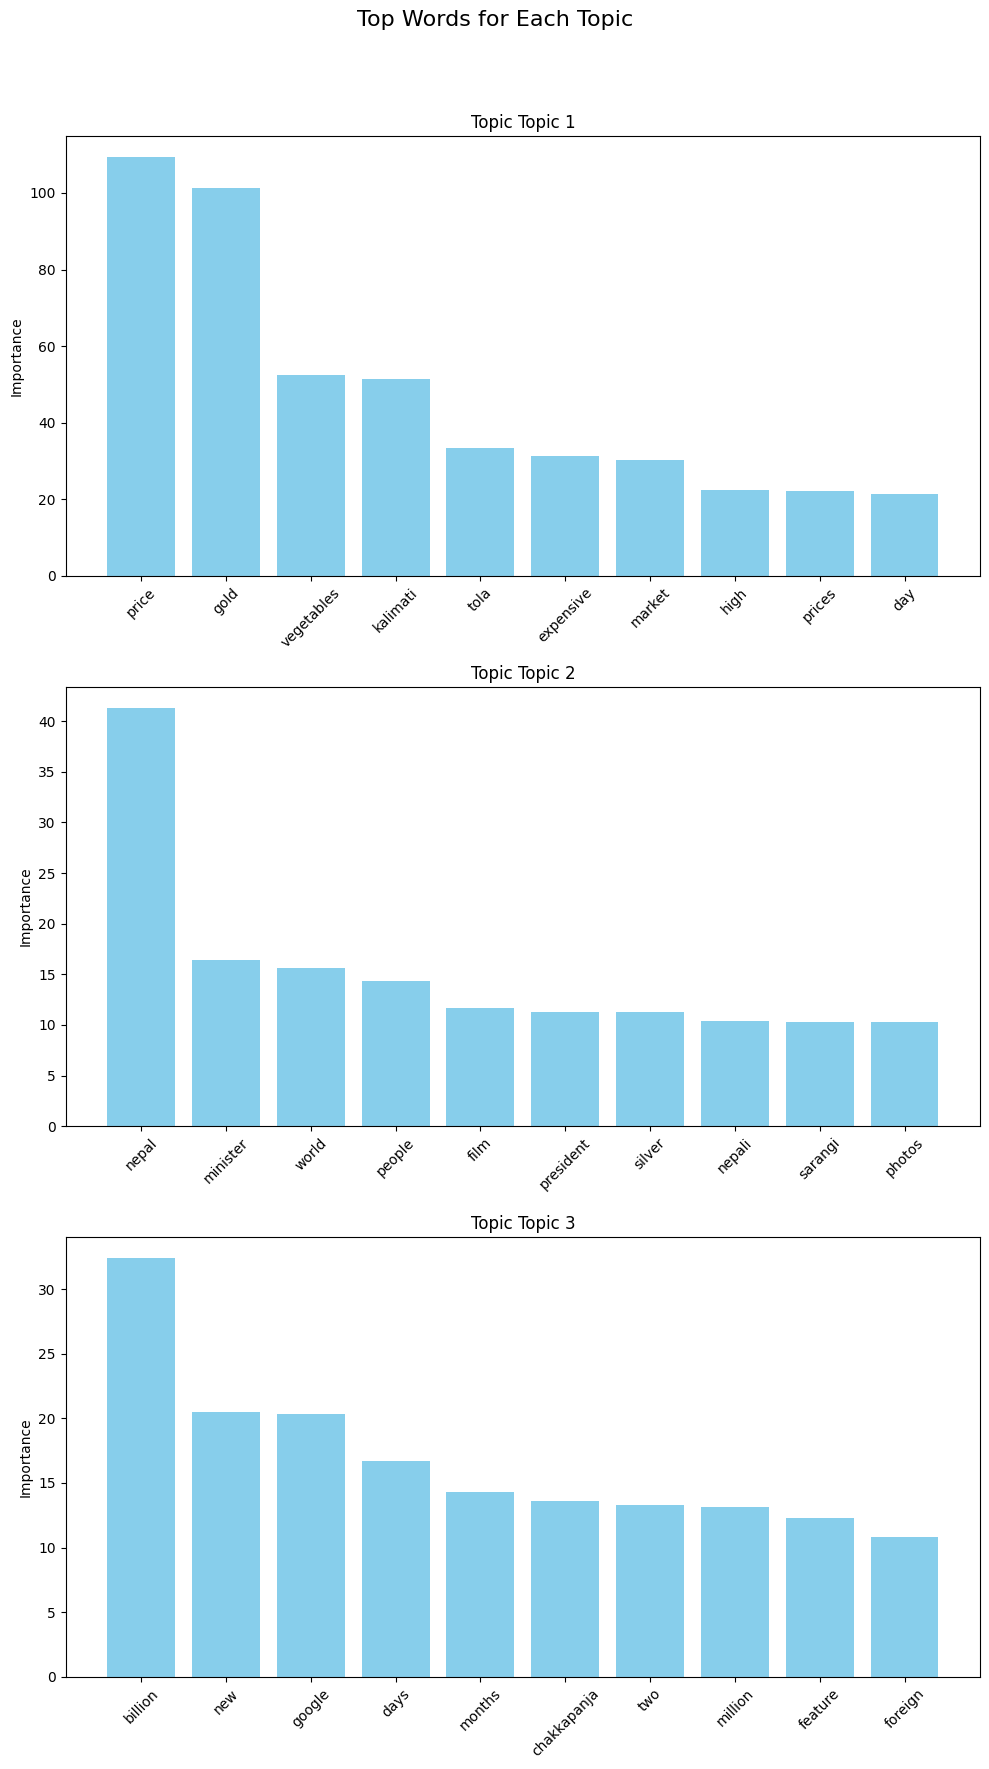

In [39]:
fig, axes = plt.subplots(nrows=len(topics), ncols=1, figsize=(10, 6 * len(topics)))
fig.suptitle("Top Words for Each Topic", fontsize=16)

if len(topics) == 1:  # Handle the case with only one topic
    axes = [axes]

for idx, (topic, words) in enumerate(topics.items()):
    word_importance = lda_model.components_[idx]  # Importance of words for the topic
    top_word_indices = word_importance.argsort()[-len(words):][::-1]
    top_word_scores = word_importance[top_word_indices]
    
    axes[idx].bar(words, top_word_scores, color='skyblue')
    axes[idx].set_title(f"Topic {topic}")
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].set_ylabel("Importance")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust spacing for title
plt.show()

In [42]:
import numpy as np

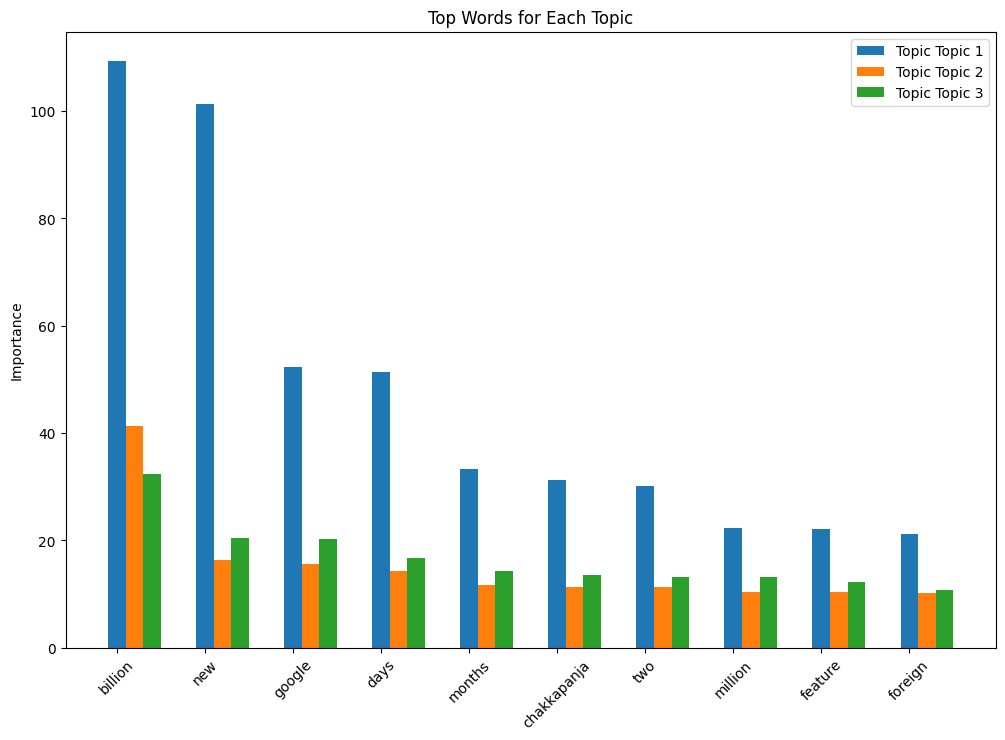

In [44]:

# Plot all topics in a single bar plot
plt.figure(figsize=(12, 8))
x_indices = np.arange(len(topics[list(topics.keys())[0]]))  # x-axis positions

for idx, (topic, words) in enumerate(topics.items()):
    word_importance = lda_model.components_[idx]
    top_word_indices = word_importance.argsort()[-len(words):][::-1]
    top_word_scores = word_importance[top_word_indices]
    
    plt.bar(x_indices + idx * 0.2, top_word_scores, width=0.2, label=f"Topic {topic}")

plt.xticks(x_indices, words, rotation=45)
plt.title("Top Words for Each Topic")
plt.legend()
plt.ylabel("Importance")
plt.show()


In [45]:
word_sentiment_data = defaultdict(lambda: defaultdict(list))
for _, row in df.iterrows():
    cleaned_text = row['cleaned_title']
    words = cleaned_text.split()
    for word in words:
        word_sentiment_data[word][row['en_timestamp']].append(row['sentiment_score'])

In [46]:
trend_data = []
for word, date_dict in word_sentiment_data.items():
    for date, scores in date_dict.items():
        trend_data.append({'word': word, 'date': date, 'average_sentiment': sum(scores) / len(scores)})

trend_df = pd.DataFrame(trend_data)

C:\Users\pacharya\AppData\Local\Temp\ipykernel_17436\1202201520.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, x='word', y='average_sentiment', palette='Set2')


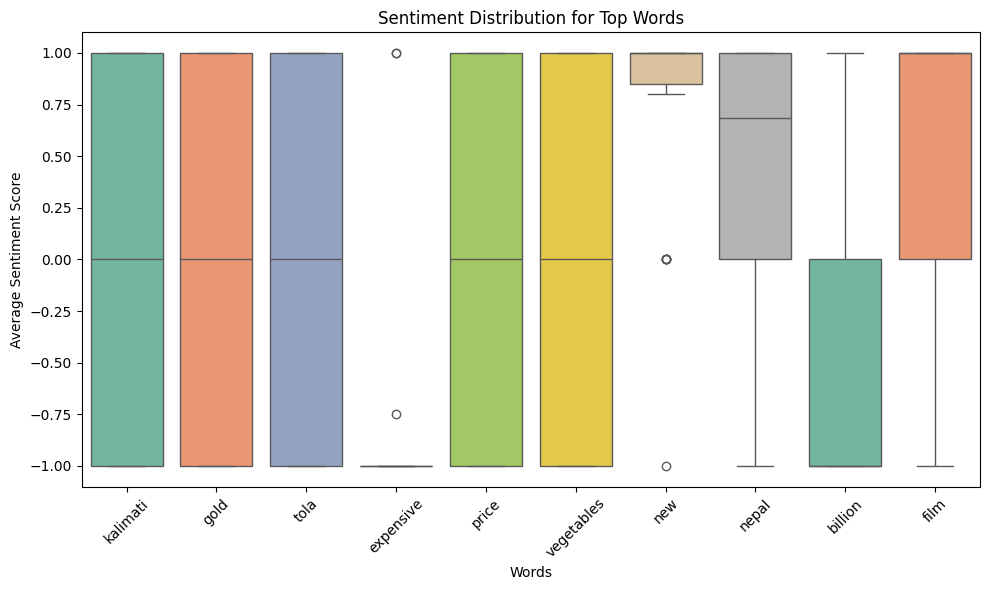

In [51]:
# Filter for words with the most frequent sentiment changes
top_words = trend_df['word'].value_counts().head(10).index
filtered_data = trend_df[trend_df['word'].isin(top_words)]

# Boxplot for sentiment distribution
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, x='word', y='average_sentiment', palette='Set2')
plt.title("Sentiment Distribution for Top Words")
plt.xlabel("Words")
plt.ylabel("Average Sentiment Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\pacharya\AppData\Local\Temp\ipykernel_17436\1841498314.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_negative_words, x='average_sentiment', y='word', ax=axes[0], palette='Reds_r')
C:\Users\pacharya\AppData\Local\Temp\ipykernel_17436\1841498314.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_positive_words, x='average_sentiment', y='word', ax=axes[1], palette='Greens')


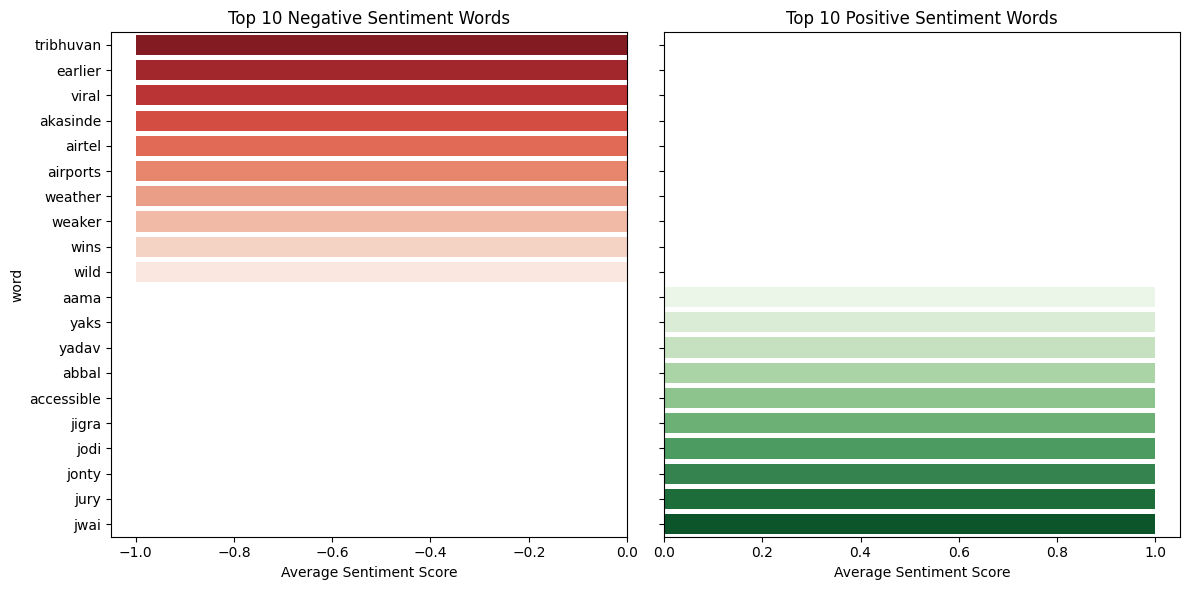

In [53]:
# Calculate average sentiment for each word
word_avg_sentiment = trend_df.groupby('word')['average_sentiment'].mean().reset_index()

# Sort by sentiment
top_negative_words = word_avg_sentiment.sort_values(by='average_sentiment').head(10)
top_positive_words = word_avg_sentiment.sort_values(by='average_sentiment', ascending=False).head(10)

# Plot positive and negative words
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Negative sentiment words
sns.barplot(data=top_negative_words, x='average_sentiment', y='word', ax=axes[0], palette='Reds_r')
axes[0].set_title("Top 10 Negative Sentiment Words")
axes[0].set_xlabel("Average Sentiment Score")

# Positive sentiment words
sns.barplot(data=top_positive_words, x='average_sentiment', y='word', ax=axes[1], palette='Greens')
axes[1].set_title("Top 10 Positive Sentiment Words")
axes[1].set_xlabel("Average Sentiment Score")

plt.tight_layout()
plt.show()


In [48]:
print("Top Words for Each Topic (LDA):")
for topic, words in topics.items():
    print(f"{topic}: {', '.join(words)}")

Top Words for Each Topic (LDA):
Topic 1: price, gold, vegetables, kalimati, tola, expensive, market, high, prices, day
Topic 2: nepal, minister, world, people, film, president, silver, nepali, sarangi, photos
Topic 3: billion, new, google, days, months, chakkapanja, two, million, feature, foreign


In [49]:
print("Word Sentiment Trends Over Time")
display(trend_df.head())

Word Sentiment Trends Over Time


,word,date,average_sentiment
0,cauliflower,2024-11-07 08:38:00,1.0
1,greens,2024-11-07 08:38:00,1.0
2,greens,2024-10-20 09:28:00,1.0
3,greens,2024-10-03 08:48:00,-1.0
4,cheaper,2024-11-07 08:38:00,1.0


In [50]:
trend_df.to_csv("word_sentiment_trends.csv", index=False)